![Insper](https://github.com/danielscarvalho/Insper-DS-Dicas/blob/master/Insper-Logo.png?raw=true)

# Insper Pós-Graduação
## Programa Avançado em Data Science e Decisão [»](https://www.insper.edu.br/pos-graduacao/programas-avancados/programa-avancado-em-data-science-e-decisao/)


# Atividade Integradora
## Setup

### Dependências

In [84]:
import pandas as pd
import numpy as np
from dfply import *
import altair as alt
import missingno as msno
from ydata_profiling import ProfileReport
import matplotlib
import matplotlib.pyplot as plt 
import math
import seaborn as sns
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm

### Carregamento dos Dados

Leitura da base de dados e do dicionários de dados

In [85]:
data = pd.read_csv("cs_bisnode_panel.csv")
dicionario_de_dados_0 = pd.read_excel("bisnode_variable_names.xls", header=4)

Visualização inicial da base de dados

In [86]:
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.6,7266.7,7574.1,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.7,13122.2,12211.1,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.9,8196.3,7800.0,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.0,8485.2,7781.5,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.4,5137.0,15300.0,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.1


In [87]:
data.describe()

,comp_id,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,...,ceo_count,foreign,female,birth_year,inoffice_days,nace_main,ind2,ind,urban_m,labor_avg
count,287829.0,18257.0,279789.0,287698.0,287698.0,269300.0,269300.0,270626.0,17485.0,287698.0,...,231402.0,231402.0,231402.0,176011.0,231402.0,286791.0,286791.0,278060.0,287829.0,141297.0
mean,154086230015.6,460168.3,23532.6,220939.5,174249.9,1521.7,3754.5,2229.1,105648.1,339373.1,...,1.3,0.1,0.3,1964.9,3205.3,4858.2,48.4,2.7,2.1,1.0
std,138242419520.0,2614148.7,821666.8,4182019.9,3730357.2,72373.4,172779.4,161116.9,533805.3,18231763.2,...,0.5,0.3,0.4,11.5,1880.6,1250.0,12.6,0.5,0.8,4.8
min,1001034.0,-844570.4,-307670.4,-555555.6,-772711.1,-490270.3,-274407.4,-6181263.0,0.0,-2394226.0,...,1.0,0.0,0.0,1920.0,1.0,111.0,1.0,1.0,1.0,0.0
25%,28686346240.0,0.0,33.3,2203.7,1833.3,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1956.0,1775.0,3314.0,33.0,2.0,1.0,0.1
50%,115285049344.0,7040.7,781.5,9592.6,10492.6,0.0,0.0,0.0,0.0,3825.9,...,1.0,0.0,0.0,1966.0,2838.0,5610.0,56.0,3.0,2.0,0.2
75%,259395780608.0,106300.0,4003.7,35521.3,41018.5,0.0,0.0,0.0,359.3,35939.8,...,1.0,0.0,0.5,1974.0,4468.8,5610.0,56.0,3.0,3.0,0.6
max,464120938496.0,94996928.0,182088896.0,1299011072.0,1683374080.0,17041718.0,72330776.0,72330776.0,18036354.0,7940211200.0,...,15.0,1.0,1.0,2016.0,10983.0,9609.0,96.0,3.0,3.0,219.3


## Dicionário de dados
### Limpeza

Ao carregar o dicionário de dados a primeira coluna pega seu nome da quarta linha da tabela (argumento `header=4` acima). As outras três colunas são nomeadas abaixo.

In [88]:
dicionario_de_dados_1 = dicionario_de_dados_0.rename({'Unnamed: 1': 'description',
                                                      'Unnamed: 2': 'type',
                                                      'Unnamed: 3': 'footnote'},
                                                     axis=1)

In [89]:
dicionario_de_dados_1.columns

Index(['variable', 'description', 'type', 'footnote'], dtype='object')

Então, retiramos as linhas não relevantes para a análise, incluindo linhas totalmente em branco e uma linha com informação de versão da base de dados: 
 - `v 0.92. 2021-02-04`

In [90]:
dicionario_de_dados = dicionario_de_dados_1\
                       .drop(index=54)\
                       .dropna(how="all")\
                       .reset_index()\
                       .drop('index', axis='columns')

In [91]:
dicionario_de_dados.sample(5)

,variable,description,type,footnote
21,sales,Total sales,numeric,(euros)
17,net_dom_sales,net domestic sales,numeric,(euros)
40,ind2,"NACE industry code, 2 digits",categorical,NaN
13,intang_assets,intangible assets,numeric,(euros)
46,labor_avg,Number of emplyoees (annual average),numeric,"N/12 --- (annual average / 12, it's not ideal,..."


## Dados faltantes
---

###  Visualização
Vamos verificar dados faltando do banco de dados:

Criação de função para analisar os dados faltantes.

In [92]:
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'pc_missing': pc_missing
    })    
        
    return output

Verificando dados com maior falta de informações:

In [93]:
missing_data = show_missing(data).sort_values('pc_missing', ascending=False, ignore_index = True)

index_full_data = list(missing_data[missing_data['missing']==0].index)

missing_data.drop(labels=index_full_data, axis='index', inplace=True)

missing_data.head(10)

,variable,dtype,count,unique,missing,pc_missing
0,D,float64,287829,1,287829,100.0
1,finished_prod,float64,287829,4207,270344,93.9
2,wages,float64,287829,13011,269846,93.8
3,COGS,float64,287829,9791,269572,93.7
4,net_exp_sales,float64,287829,7085,269572,93.7
5,net_dom_sales,float64,287829,15052,269572,93.7
6,exit_year,float64,287829,19,248970,86.5
7,exit_date,object,287829,2603,231649,80.5
8,labor_avg,float64,287829,5824,146532,50.9
9,birth_year,float64,287829,265,111818,38.9


In [94]:
missing_val_columns = missing_data['variable'][missing_data['pc_missing']>0]

<Axes: >

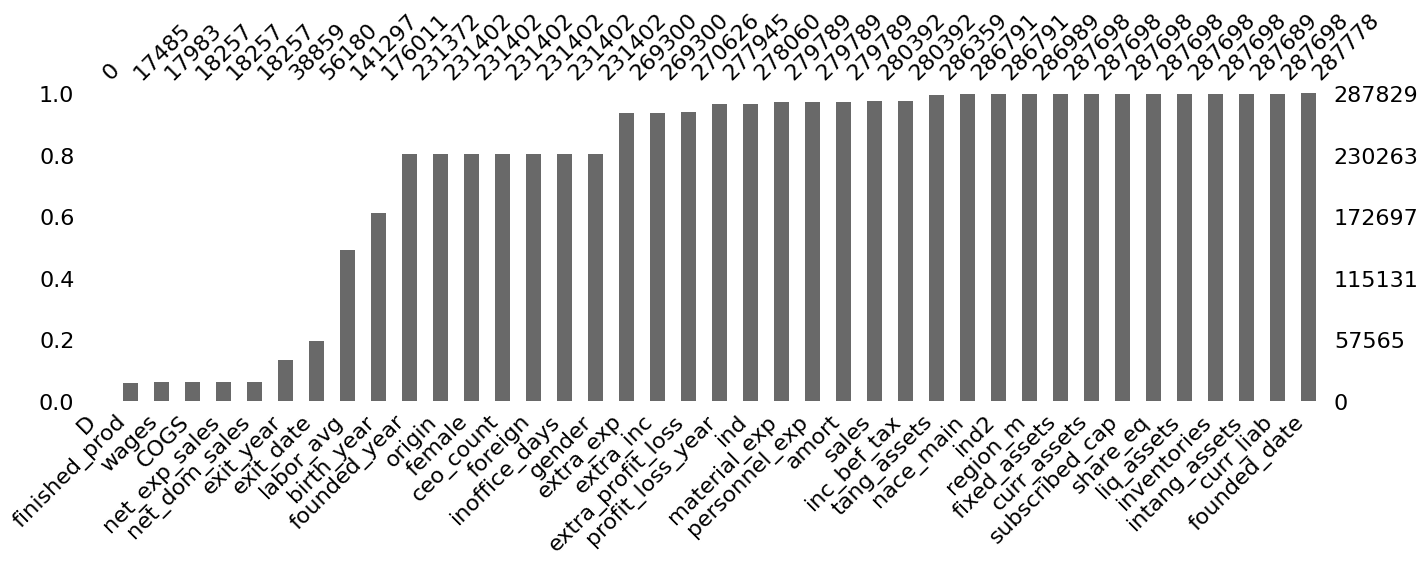

In [95]:
msno.bar(data[missing_val_columns], figsize=(16, 4))

### Colunas com poucos dados
Removemos aqui seis colunas tem mais de 90% de dados faltantes, removemos as colunas "begin" e "end" que contêm informação sobre o período a que os dados dizem respeito pois consideramos na análise essa mesma informação contida na variável "year". Removemos também as variáveis 'exit_year' e 'exit_data', visto que o encerrameto da empresa é definido com base na variável 'sales'.

In [96]:
columns_to_remove = ['COGS',
                     'finished_prod',
                     'net_dom_sales',
                     'net_exp_sales',
                     'wages',
                     'D',
                     'begin',
                     'end',
                     'exit_year',
                     'exit_date'] 

data.drop(columns=columns_to_remove, inplace=True)

data.columns

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_flag', 'balsheet_length',
       'balsheet_notfullyear', 'year', 'founded_year', 'ceo_count', 'foreign',
       'female', 'birth_year', 'inoffice_days', 'gender', 'origin',
       'nace_main', 'ind2', 'ind', 'urban_m', 'region_m', 'founded_date',
       'labor_avg'],
      dtype='object')

### "founded_year"
Aproveitamos para tratar aqui a variável "founded_year" que utilizamos mais à frente na criação da feature "company_age".

In [97]:
missing_data.loc[missing_data['variable'].isin(['founded_year','founded_date'])]

,variable,dtype,count,unique,missing,pc_missing
10,founded_year,float64,287829,39,56457,19.6
39,founded_date,object,287829,6363,51,0.0


Convertemos 'founde_date' para datetime.

In [98]:
data.dtypes['founded_date']

dtype('O')

In [99]:
data['founded_date'] = pd.to_datetime(data['founded_date'], format='%Y-%m-%d')

data['founded_date'].dtypes

dtype('<M8[ns]')

Utilizamos a variável "founded_date" (que tem uma menor proporção de valores faltantes) para preencher alguns dos valores faltantes em "founded_year" (que tem a granularidade desejada para a análise).

In [100]:
assert any(data.loc[(data['founded_date'].isna() & 
                     data['founded_year'].isna()),
                    'comp_id'].count() ==\
           missing_data.loc[missing_data['variable'] == 'founded_date', 'missing'])

As observações sem informação em "founded_date" também não tem informação para "founded_year" e são retiradas.

In [101]:
# Remove linhas onde 'founded_date' é NaN
data = data.dropna(subset=['founded_date'])

# Extrai o ano de 'founded_date' e substitui os valores ausentes em 'founded_year'
data['founded_year'] = data['founded_date'].dt.year

# Descarta a coluna 'founded_date', pois o ano de fundação da empresa é suficiente
data = data.drop(columns=['founded_date'])

### Checkpoint
Análise dos percentuais de missing após os tratamentos.

In [102]:
missing_data2 = show_missing(data).sort_values('pc_missing', ascending=False, ignore_index = True)

index_full_data = list(missing_data2[missing_data2['missing']==0].index)

missing_data2.drop(labels=index_full_data, axis='index', inplace=True)

missing_data2

,variable,dtype,count,unique,missing,pc_missing
0,labor_avg,float64,287778,5824,146488,50.9
1,birth_year,float64,287778,265,111778,38.8
2,gender,object,287778,4,56406,19.6
3,foreign,float64,287778,16,56406,19.6
4,female,float64,287778,15,56406,19.6
5,inoffice_days,float64,287778,11178,56406,19.6
6,origin,object,287778,4,56406,19.6
7,ceo_count,float64,287778,15,56406,19.6
8,extra_inc,float64,287778,8176,18526,6.4
9,extra_exp,float64,287778,4254,18526,6.4


### Colunas com dados quase completos

Aqui tratamos as colunas com 5% ou menos dados faltantes. Primeiramente checamos se esses dados estão faltando nas mesmas observações ou se estão distribuidos em observações diferentes.

In [103]:
# Lista de colunas com menos de 5% de dados ausentes

cols = list(missing_data2['variable'][missing_data2['pc_missing']<5.0])

# Verifica quais linhas possuem dados ausentes nessas colunas

missing_rows = data[cols].isnull().any(axis=1)      

# Calcula o percentual de linhas com dados ausentes

pc_missing_rows = 100 * missing_rows.sum() / len(data)

print(f'Percentual de linhas com dados ausentes em pelo menos uma das colunas mencionadas: {pc_missing_rows:.2f}%')

Percentual de linhas com dados ausentes em pelo menos uma das colunas mencionadas: 10.09%


In [104]:
# Remove variáveis com menos de 5% de dados ausentes
removable_na_columns = list(missing_data2['variable'][missing_data2['pc_missing']<5.0])

data.dropna(subset=removable_na_columns, inplace=True)

Valores faltantes após os tratamentos.

In [105]:
missing_data_3 = show_missing(data).sort_values('pc_missing', ascending=False, ignore_index = True)

index_full_data = list(missing_data_3[missing_data_3['missing']==0].index)

missing_data_3.drop(labels=index_full_data, axis='index', inplace=True)

missing_data_3

,variable,dtype,count,unique,missing,pc_missing
0,labor_avg,float64,258734,5385,132558,51.2
1,birth_year,float64,258734,261,100053,38.7
2,origin,object,258734,4,50571,19.6
3,ceo_count,float64,258734,15,50571,19.6
4,foreign,float64,258734,16,50571,19.6
5,female,float64,258734,15,50571,19.6
6,gender,object,258734,4,50571,19.6
7,inoffice_days,float64,258734,10876,50571,19.6
23,extra_exp,float64,258734,4070,5,0.0
24,extra_inc,float64,258734,7908,5,0.0


<Axes: >

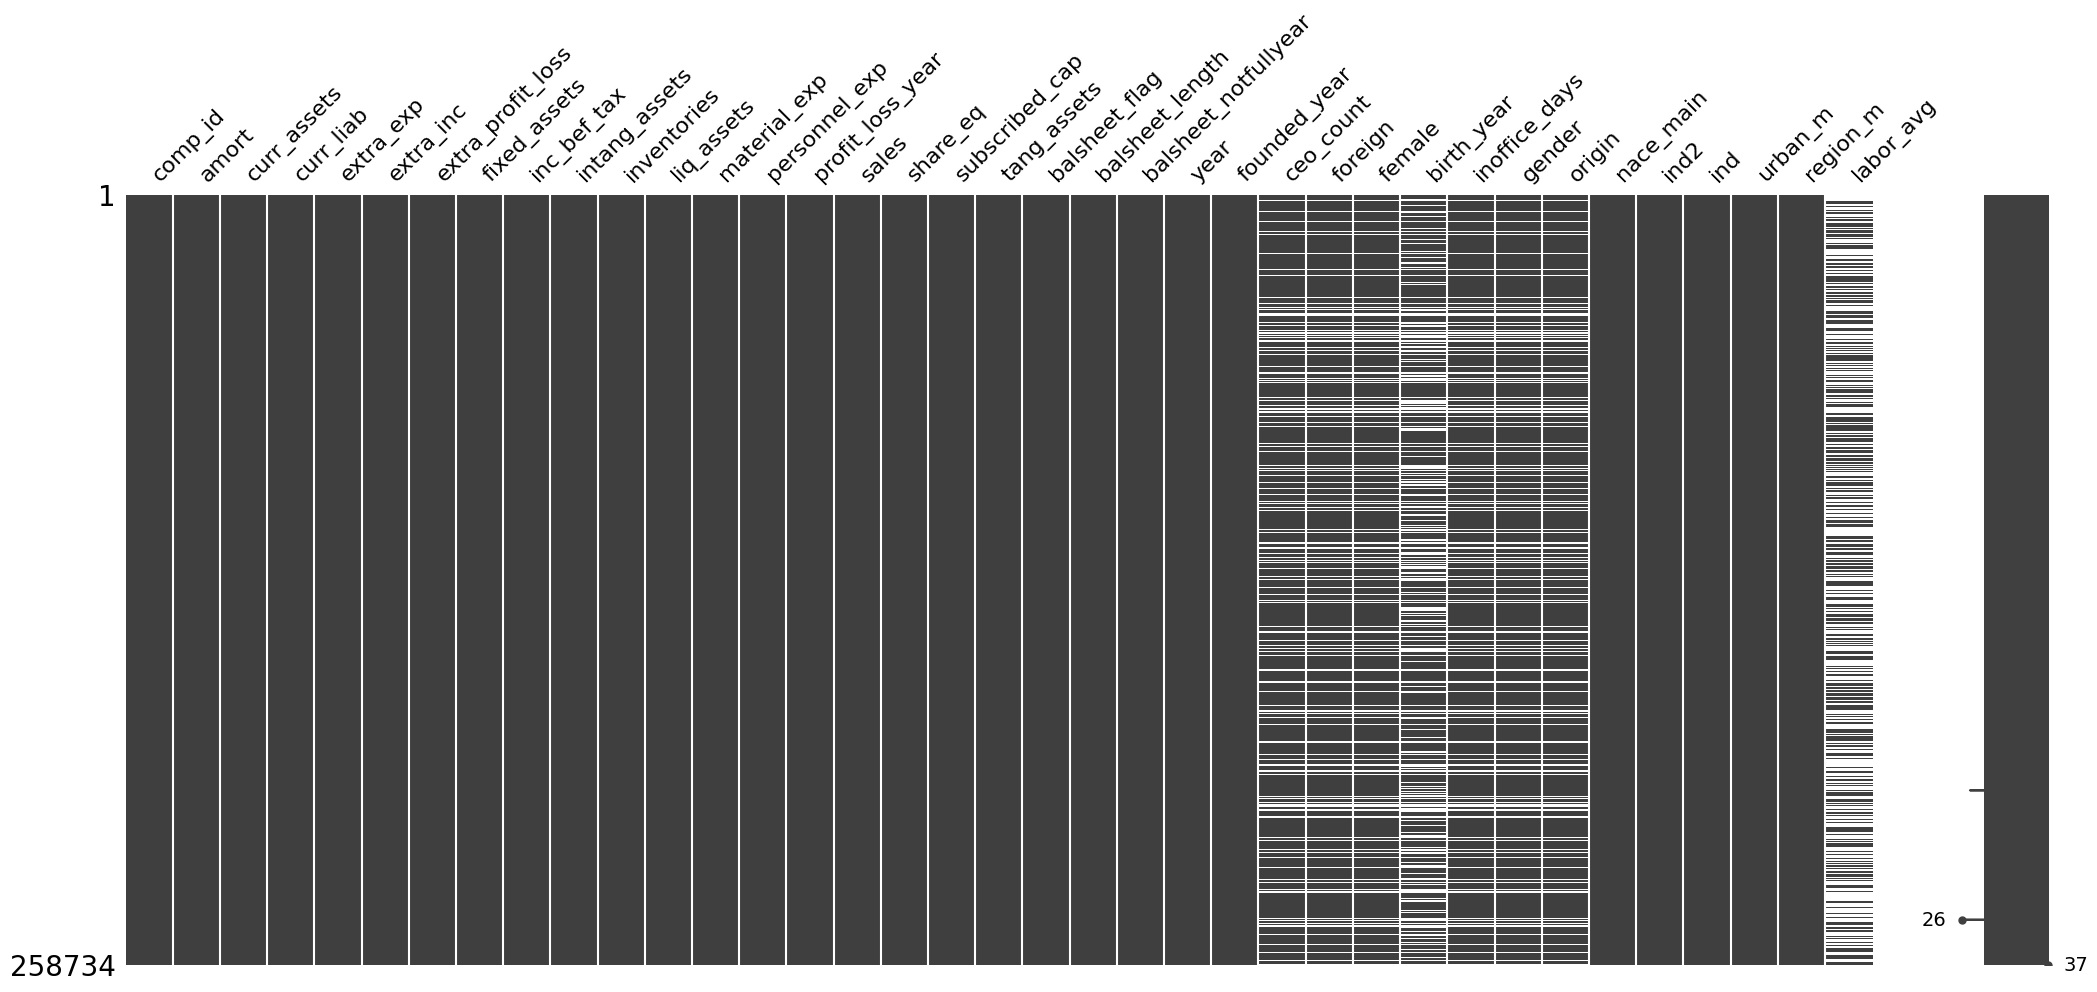

In [106]:
msno.matrix(data)

A tabela mostra 6 variáveis com cerca de 20% de dados faltantes nesse ponto da análise, e o gráfico indica que essa ausência de dados coincide nas mesmas observações. Optamos por deixar essas observações apesar da coincidência de dados faltantes, e tratar as faltas mais abaixo.

## Tratamento de demais variáveis com MICE

Os demais valores ausentes são preenchidos utilizando o método MICE (Multiple Imputation by Chained Equations) com a biblioteca 'IterativeImputer' do sklearn. 



In [107]:
data.reindex()

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,...,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,labor_avg
0,1001034.0,692.6,7266.7,7574.1,0.0,0.0,0.0,1229.6,218.5,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
1,1001034.0,603.7,13122.2,12211.1,0.0,0.0,0.0,725.9,996.3,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
2,1001034.0,425.9,8196.3,7800.0,0.0,0.0,0.0,1322.2,570.4,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
3,1001034.0,300.0,8485.2,7781.5,0.0,0.0,0.0,1022.2,714.8,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
4,1001034.0,207.4,5137.0,15300.0,0.0,0.0,0.0,814.8,-11044.4,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287824,464120938496.0,0.0,1807.4,3.7,0.0,0.0,0.0,0.0,25.9,0.0,...,NaN,8187.0,female,Domestic,5510.0,55.0,3.0,2,East,NaN
287825,464120938496.0,0.0,1518.5,96.3,0.0,0.0,0.0,0.0,-381.5,0.0,...,NaN,8187.0,female,Domestic,5510.0,55.0,3.0,2,East,NaN
287826,464120938496.0,0.0,988.9,77.8,0.0,0.0,0.0,0.0,-511.1,0.0,...,NaN,NaN,NaN,NaN,5510.0,55.0,3.0,2,East,NaN
287827,464120938496.0,0.0,644.4,233.3,0.0,0.0,0.0,0.0,-500.0,0.0,...,1942.0,1441.0,female,Domestic,5510.0,55.0,3.0,2,East,NaN


Antes de proceder com a imputação usando o método MICE, é importante converter certas variáveis para o tipo categórico. Isso garante que essas variáveis sejam tratadas de maneira adequada durante o processo de imputação.

In [108]:
# Lista das colunas para transformar em categóricas
colunas_para_converter = ['balsheet_flag', 'balsheet_notfullyear', 'gender', 'origin', 'ind2', 'ind', 'urban_m', 'region_m']

# Convertendo as colunas para o tipo 'category'
data[colunas_para_converter] = data[colunas_para_converter].astype('category')

# Verificando os tipos das colunas após a conversão
print(data[colunas_para_converter].dtypes)


balsheet_flag           category
balsheet_notfullyear    category
gender                  category
origin                  category
ind2                    category
ind                     category
urban_m                 category
region_m                category
dtype: object


In [109]:
df_mice = data.copy()
df_mice.head()

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,...,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,labor_avg
0,1001034.0,692.6,7266.7,7574.1,0.0,0.0,0.0,1229.6,218.5,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
1,1001034.0,603.7,13122.2,12211.1,0.0,0.0,0.0,725.9,996.3,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
2,1001034.0,425.9,8196.3,7800.0,0.0,0.0,0.0,1322.2,570.4,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
3,1001034.0,300.0,8485.2,7781.5,0.0,0.0,0.0,1022.2,714.8,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,NaN
4,1001034.0,207.4,5137.0,15300.0,0.0,0.0,0.0,814.8,-11044.4,0.0,...,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,0.1


In [110]:
# Copia o df_mice para criar variáveis dummy
df_mice2 = df_mice.copy()
df_mice2 = pd.get_dummies(df_mice2)

In [111]:
# Define Input de MICE e preenche NaN 

mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice2), columns=df_mice2.columns)

In [112]:
df_mice_imputed.head()

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,...,ind2_56.0,ind_1.0,ind_2.0,ind_3.0,urban_m_1,urban_m_2,urban_m_3,region_m_Central,region_m_East,region_m_West
0,1001034.0,692.6,7266.7,7574.1,0.0,0.0,0.0,1229.6,218.5,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1001034.0,603.7,13122.2,12211.1,0.0,0.0,0.0,725.9,996.3,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1001034.0,425.9,8196.3,7800.0,0.0,0.0,0.0,1322.2,570.4,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1001034.0,300.0,8485.2,7781.5,0.0,0.0,0.0,1022.2,714.8,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1001034.0,207.4,5137.0,15300.0,0.0,0.0,0.0,814.8,-11044.4,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [113]:
missing_data_3 = show_missing(df_mice_imputed).sort_values("pc_missing", ascending=False, ignore_index = True)

missing_data_3

,variable,dtype,count,unique,missing,pc_missing
0,comp_id,float64,258734,44558,0,0.0
1,amort,float64,258734,19928,0,0.0
2,balsheet_flag_1,float64,258734,2,0,0.0
3,balsheet_notfullyear_0,float64,258734,2,0,0.0
4,balsheet_notfullyear_1,float64,258734,2,0,0.0
5,gender_female,float64,258734,2,0,0.0
6,gender_male,float64,258734,2,0,0.0
7,gender_mix,float64,258734,2,0,0.0
8,origin_Domestic,float64,258734,2,0,0.0
9,origin_Foreign,float64,258734,2,0,0.0


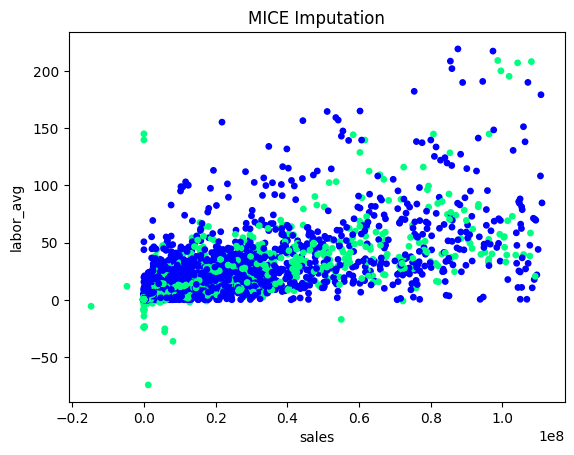

In [114]:
# Verifica dados imputados 

# MICE imputação
fig = plt.Figure()
null_values = data['labor_avg'].isnull() 
fig = df_mice_imputed.plot(x='sales', y='labor_avg', kind='scatter',
                           c=null_values, cmap='winter', s = 15,
                           title='MICE Imputation', colorbar=False)

In [115]:
df_mice_imputed.columns

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_length', 'year',
       'founded_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'nace_main', 'labor_avg', 'balsheet_flag_0',
       'balsheet_flag_1', 'balsheet_notfullyear_0', 'balsheet_notfullyear_1',
       'gender_female', 'gender_male', 'gender_mix', 'origin_Domestic',
       'origin_Foreign', 'origin_mix', 'ind2_26.0', 'ind2_27.0', 'ind2_28.0',
       'ind2_29.0', 'ind2_30.0', 'ind2_33.0', 'ind2_55.0', 'ind2_56.0',
       'ind_1.0', 'ind_2.0', 'ind_3.0', 'urban_m_1', 'urban_m_2', 'urban_m_3',
       'region_m_Central', 'region_m_East', 'region_m_West'],
      dtype='object')

Reverte o processo de pd.get_dummies com base no df_mice_imputed

In [116]:
missing_data_4 = show_missing(df_mice_imputed).sort_values("pc_missing", ascending=False, ignore_index = True)

missing_data_4.sort_values(by="variable", ignore_index=True)

,variable,dtype,count,unique,missing,pc_missing
0,amort,float64,258734,19928,0,0.0
1,balsheet_flag_0,float64,258734,2,0,0.0
2,balsheet_flag_1,float64,258734,2,0,0.0
3,balsheet_length,float64,258734,366,0,0.0
4,balsheet_notfullyear_0,float64,258734,2,0,0.0
5,balsheet_notfullyear_1,float64,258734,2,0,0.0
6,birth_year,float64,258734,100313,0,0.0
7,ceo_count,float64,258734,50585,0,0.0
8,comp_id,float64,258734,44558,0,0.0
9,curr_assets,float64,258734,52115,0,0.0


## Feature Engineering
---

### Variável Dependente - Inatividade da Empresa
Chamamos "inativas" aquelas empresas que não apresentam vendas nos dois anos seguintes ao ano observado.\
**Nota:** ativa = 0, inativa = 1

In [117]:
# Ordena o DataFrame por empresa e ano
df_mice_imputed.sort_values(by=['comp_id', 'year'], inplace=True)

# Cria colunas deslocadas para checar vendas nos dois anos seguintes
conditions_x1 = [((df_mice_imputed['comp_id'] == df_mice_imputed['comp_id'].shift(-1)) &
                  (df_mice_imputed['year'] == df_mice_imputed['year'].shift(-1) - 1)),

                 ((df_mice_imputed['comp_id'] != df_mice_imputed['comp_id'].shift(-1)) |
                  df_mice_imputed['year'] != df_mice_imputed['year'].shift(-1))]

values_x1 = [df_mice_imputed['sales'].shift(-1),
             np.nan]

df_mice_imputed['sales_x1'] = pd.Series(np.select(conditions_x1, values_x1)).fillna(0)


conditions_x2 = [
    ((df_mice_imputed['comp_id'] == df_mice_imputed['comp_id'].shift(-1)) &   
     (df_mice_imputed['year'] == df_mice_imputed['year'].shift(-1) - 2)),

    ((df_mice_imputed['comp_id'] == df_mice_imputed['comp_id'].shift(-2)) &
     (df_mice_imputed['year'] == df_mice_imputed['year'].shift(-2) - 2)),

    True
]

values_x2 = [df_mice_imputed['sales'].shift(-1),
             df_mice_imputed['sales'].shift(-2),
             np.nan]

df_mice_imputed['sales_x2'] = pd.Series(np.select(conditions_x2, values_x2)).fillna(0)


# Define condicao usada para identificar empresas que pararam de operar:
#  - sem vendas por mais de 2 anos
condition = ((df_mice_imputed['sales_x1'] == 0) & (df_mice_imputed['sales_x2'] == 0)) 

# Create a new 'dependente' column with 1 for ceased companies and 0 otherwise
df_mice_imputed['fechado'] = condition.astype(int)

Vamos conferir os valores da variavel dependente para algumas empresas do dataframe:

In [118]:
# lista de colunas para avaliação
check_list = ['comp_id', 'year', 'sales', 'sales_x1', 'sales_x2', 'fechado']

filtro = df_mice_imputed[check_list]
filtro_sub = filtro[(filtro['comp_id'] == 464021159936) | (filtro['comp_id'] == 1001541)]

filtro_sub

,comp_id,year,sales,sales_x1,sales_x2,fechado
11,1001541.0,2009.0,925.9,0.0,0.0,1
12,1001541.0,2010.0,0.0,0.0,1203.7,0
13,1001541.0,2011.0,0.0,1203.7,5555.6,0
14,1001541.0,2012.0,1203.7,5555.6,4888.9,0
15,1001541.0,2013.0,5555.6,4888.9,4888.9,0
16,1001541.0,2014.0,4888.9,4888.9,0.0,0
17,1001541.0,2015.0,4888.9,0.0,0.0,1
258693,464021159936.0,2007.0,40677.8,66507.4,71685.2,0
258694,464021159936.0,2008.0,66507.4,71685.2,29374.1,0
258695,464021159936.0,2009.0,71685.2,29374.1,50474.1,0


In [119]:
# Remodela os dados de vendas para tratar valores negativos
df_mice_imputed['sales'] = np.where(df_mice_imputed['sales']<0, 0, df_mice_imputed['sales'])

df_mice_imputed['fechado'] = condition.astype(int)

In [120]:
df_mice_imputed[check_list].describe()

,comp_id,year,sales,sales_x1,sales_x2,fechado
count,258734.0,258734.0,258734.0,258734.0,258734.0,258734.0
mean,154017070932.1,2010.4,473191.6,417410.1,366322.2,0.3
std,138265850982.6,3.1,3775402.4,3478152.0,3251652.8,0.4
min,1001034.0,2005.0,0.0,-4730166.5,-255388.9,0.0
25%,28572901376.0,2008.0,4744.4,0.0,0.0,0.0
50%,115307831296.0,2011.0,30422.2,20229.6,7463.0,0.0
75%,259326525440.0,2013.0,110669.4,92632.4,70321.3,1.0
max,464120938496.0,2015.0,111029448.0,111029448.0,111029448.0,1.0


Vamos averiguar agora os anos em que as empresas tiveram atividade e inatividade:

In [121]:
# Converte "comp_id" para float antes de agrupar
df_mice_imputed['comp_id'] = df_mice_imputed['comp_id'].astype(float)

data_grouped = df_mice_imputed.groupby('comp_id')

# Conta anos de acompanhamento
comp_years = data_grouped['year'].count()

# Conta anos com vendas
sales_years = data_grouped.apply(lambda group: (group['sales'] > 0).sum())

# Conta anos sem vendas
no_sales_years = data_grouped.apply(lambda group: (group['sales'] == 0).sum())

# Conta anos de "inatividade"
inative_years = data_grouped.apply(lambda group: (group['fechado'] == 1).sum())

In [122]:
pd.options.display.float_format = '{:.1f}'.format

activity_df = pd.DataFrame({'Total years':comp_years,
                            'Sales years':sales_years, 
                            'No sales years':no_sales_years,
                            'Inative years':inative_years}).reset_index()

activity_df['comp_id'] = activity_df['comp_id'].astype(float)
activity_df.head()

,comp_id,Total years,Sales years,No sales years,Inative years
0,1001034.0,11,6,5,6
1,1001541.0,7,5,2,2
2,1002029.0,9,9,0,1
3,1003200.0,8,8,0,1
4,1004012.0,8,8,0,1


## Seleção de subset para análise
---
A modelagem é feita em cima de um subset dos dados com o objetivo de adicionar foco à analise e facilitar o processamento por estar trabalhando com menor volume de dados. O escopo desse subset pode ser adaptado iterativamente, atendendo a demandas que surjam na análise.

### Removendo dados do ano 2016
Registros do ano de 2016 são removidos do conjunto.

In [123]:
df_mice_imputed = df_mice_imputed[df_mice_imputed['year']!=2016].copy()
assert not any(df_mice_imputed["year"] == 2016)

### Ano

In [124]:
# Cria dataframe apenas com os dados do ano de 2012
data_2012 = df_mice_imputed[df_mice_imputed['year'] == 2012].copy()

assert data_2012.year.unique() == 2012 # verificando coluna de ano

### Tamanho da Empresa

In [125]:
# Considera apenas sales > 1000 e < 10000000
data_2012 = data_2012[(data_2012['sales'] > 1000) & (data_2012['sales'] < 10000000) ]

Verificando colunas com valores negativos

In [126]:
# Identificando colunas com valores númericos no data_2012
numeric_cols_2012 = data_2012.select_dtypes(include=[np.number]).columns

# Creando dicionário para armazenar colunas com valores negativos 
negative_values_2012 = {}

# Iteração nas colunas númericas para encontrar valores negativos
for col in numeric_cols_2012:
    negative_count = (data_2012[col] < 0).sum()
    if negative_count > 0:
        negative_values_2012[col] = negative_count

# Mostrar colunas com valores negativos e contagem de valores negativos
negative_values_2012

{'amort': 6,
 'curr_assets': 11,
 'curr_liab': 11,
 'extra_exp': 3,
 'extra_inc': 2,
 'extra_profit_loss': 1246,
 'inc_bef_tax': 9696,
 'intang_assets': 2,
 'inventories': 4,
 'liq_assets': 35,
 'material_exp': 4,
 'personnel_exp': 6,
 'profit_loss_year': 9749,
 'share_eq': 7932,
 'subscribed_cap': 1,
 'labor_avg': 295,
 'sales_x1': 1,
 'sales_x2': 2}

Analisando as colunas com valores negativos, é constatado que faz sentido ter valores negativos nas colunas 'extra_profit_loss',  'inc_bef_tax', 'profit_loss_year' e  'share_eq'. Enquanto nas demais colunas, não faz sentido.

In [127]:
# Lista das colunas para verificar valores negativos, excluindo as colunas que fazem sentido ter valores negativos
columns_to_check = [
    'amort', 'curr_assets', 'curr_liab', 'extra_exp', 'extra_inc', 
    'intang_assets', 'inventories', 'liq_assets', 'material_exp', 
    'personnel_exp', 'subscribed_cap', 'labor_avg', 
    'sales_x1', 'sales_x2'
]

# Identificar as colunas que possuem valores negativos 
negative_rows = [data_2012[data_2012[col] < 0].index for col in columns_to_check]

# Começar índice de valores negativos na primeira coluna 
all_negative_rows = set(negative_rows[0])

# Unir os índices de valores negativos de todas as colunas
for row_set in negative_rows[1:]:
    all_negative_rows = all_negative_rows.union(row_set)

# Número de linhas com qualquer valor negativo dessas colunas selecionadas 
len_all_negative_rows = len(all_negative_rows)

# Calcular percentual de linhas com valores negativos
percentage_any_negative = (len_all_negative_rows / len(data_2012)) * 100

# Formatar o percentual e mostrar valor
formatted_percentage_any_negative = "{:.2f}%".format(percentage_any_negative)
print(formatted_percentage_any_negative)


1.73%


In [128]:
# Para cada linha do index com valores negativos 
for row_idx in all_negative_rows:
    # Para cada coluna específica
    for col in columns_to_check:
        # Se o valor for negativo, considere como igual a 0
        if data_2012.at[row_idx, col] < 0:
            data_2012.at[row_idx, col] = 0

# Verificando se ainda tem valores negativos após o tratamento 
negative_values_after_correction = {col: data_2012[data_2012[col] < 0].shape[0] for col in columns_to_check}
negative_values_after_correction

{'amort': 0,
 'curr_assets': 0,
 'curr_liab': 0,
 'extra_exp': 0,
 'extra_inc': 0,
 'intang_assets': 0,
 'inventories': 0,
 'liq_assets': 0,
 'material_exp': 0,
 'personnel_exp': 0,
 'subscribed_cap': 0,
 'labor_avg': 0,
 'sales_x1': 0,
 'sales_x2': 0}

## Feature Engineering no Subset

### Assimetria
Nessa subsessão olhamos as medidas de assimetria das variáveis na nossa base. Para a presente análise tratamos apenas a variável "sales", criando outra variável a partir de seu logarítmo. A análise das demais variáveis é disponibilizada para interpretação e trabalho subsequente.

In [129]:
# Filtra apenas colunas numéricas para calcular assimetria
numeric_cols = data_2012.select_dtypes(include=[np.number]).columns # Avaliar a simetria das variáveis

# Avalia a simetria das colunas numéricas
skewness_values = data_2012[numeric_cols].skew()

# Ordena os valores de assimetria do maior para o menor
sorted_skewness_values = skewness_values.sort_values(ascending=False)

# Mostra os valores de assimetria ordenados
print(sorted_skewness_values)

extra_exp                143.9
extra_inc                131.7
extra_profit_loss         72.1
tang_assets               51.0
intang_assets             49.9
curr_liab                 47.1
fixed_assets              44.0
inventories               39.4
subscribed_cap            34.8
sales_x2                  30.4
amort                     27.1
liq_assets                20.9
balsheet_flag_1           20.8
share_eq                  19.3
curr_assets               15.5
sales_x1                  15.3
personnel_exp             12.2
ind2_30.0                 11.2
labor_avg                 10.1
ind2_29.0                  8.4
material_exp               8.2
sales                      7.4
ind_1.0                    6.6
origin_mix                 5.8
ind2_27.0                  5.4
ind2_26.0                  4.1
origin_Foreign             3.3
balsheet_notfullyear_1     3.3
ind2_33.0                  2.8
ind2_28.0                  2.8
gender_mix                 2.5
ind2_55.0                  2.5
fechado 

In [130]:
# Identifica colunas com assimetria significativamente diferente de zero
cols_to_transform = skewness_values[skewness_values.abs() > 0.5].index
print(cols_to_transform)

Index(['comp_id', 'amort', 'curr_assets', 'curr_liab', 'extra_exp',
       'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax',
       'intang_assets', 'inventories', 'liq_assets', 'material_exp',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'balsheet_length', 'founded_year',
       'ceo_count', 'foreign', 'female', 'inoffice_days', 'nace_main',
       'labor_avg', 'balsheet_flag_0', 'balsheet_flag_1',
       'balsheet_notfullyear_0', 'balsheet_notfullyear_1', 'gender_female',
       'gender_mix', 'origin_Domestic', 'origin_Foreign', 'origin_mix',
       'ind2_26.0', 'ind2_27.0', 'ind2_28.0', 'ind2_29.0', 'ind2_30.0',
       'ind2_33.0', 'ind2_55.0', 'ind_1.0', 'ind_2.0', 'ind_3.0', 'urban_m_1',
       'urban_m_2', 'region_m_East', 'region_m_West', 'sales_x1', 'sales_x2',
       'fechado'],
      dtype='object')


Nas estatísticas descritivas abaixo, observa-se que a média é maior que o terceiro quartil, indicando uma distribuição bastante assimétrica. Criamos então uma coluna com o logarítmo de "sales" para auxiliar na análise.

In [131]:
print(data_2012['sales'].describe())

count     20952.0
mean     229374.2
std      768238.4
min        1003.7
25%       14364.8
50%       41722.2
75%      129792.6
max     9989311.0
Name: sales, dtype: float64


A coluna log_sales mostra que, embora muitas empresas tenham vendas relativamente baixas (indicado por um logaritmo de vendas próximo ou igual a zero), há empresas que se destacam com vendas substancialmente mais altas.

In [132]:
# Função para criar coluna com logaritmo da coluna argumento
def criar_log(data_set, col):
    new_col = 'log_' + col
    data_set.loc[:,new_col] = data_set.loc[:,col]\
                                            .apply(lambda x: math.log(x)\
                                                   if x > 0\
                                                   else 0) 

In [133]:
criar_log(data_2012, 'sales')
data_2012.log_sales.describe()

count   20952.0
mean       10.7
std         1.7
min         6.9
25%         9.6
50%        10.6
75%        11.8
max        16.1
Name: log_sales, dtype: float64

A descrição acima mostra valores mais simétricos para o logarítmo de "sales", quando comparado com "sales".

#### "sales" vs "log_sales"

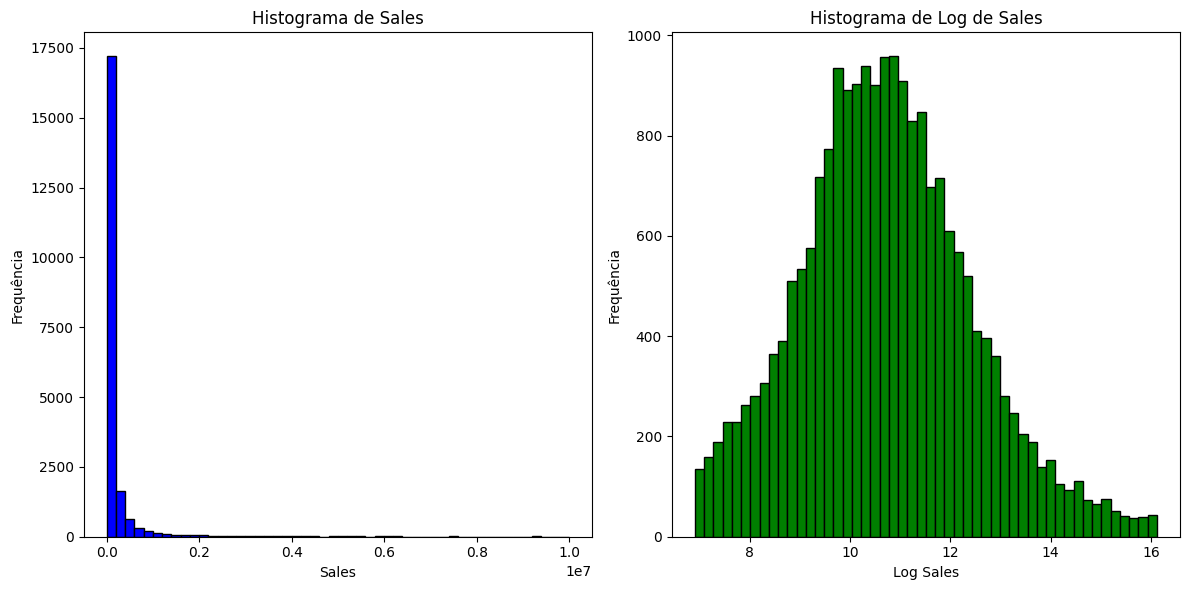

In [134]:
# Cria histogramas
plt.figure(figsize=(12, 6))

# Histograma de sales
plt.subplot(1, 2, 1)
plt.hist(data_2012['sales'], bins=50, color='blue', edgecolor='black')
plt.title('Histograma de Sales')
plt.xlabel('Sales')
plt.ylabel('Frequência')

# Histograma de log_sales
plt.subplot(1, 2, 2)
plt.hist(data_2012['log_sales'], bins=50, color='green', edgecolor='black')
plt.title('Histograma de Log de Sales')
plt.xlabel('Log Sales')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


#### Idade da Empresa

In [135]:
data_2012['company_age'] = 2012 - data_2012['founded_year']

#### Outras Features

A fim de aprimorar a precisão e eficácia de nosso modelo, estamos considerando a introdução de novas variáveis explanatórias. A motivação por trás dessa decisão é explorar a possibilidade de que certas variáveis, ainda não incluídas em nosso modelo, possam ter um impacto significativo no erro do modelo. Ao identificar e incorporar essas variáveis potencialmente influentes, esperamos não apenas reduzir o erro, mas também aumentar a robustez do modelo, tornando suas previsões mais confiáveis e precisas. Nos próximos passos, avaliaremos cada uma dessas variáveis, sua relevância e a maneira como elas podem ser integradas ao modelo existente.

In [136]:
# Definir função para que, se o denominador for igual a 0, retornar zero
def safe_divide(numerator, denominator, default_value=0.0):
    if denominator == 0:
        return default_value
    return numerator / denominator

# Ajustar as novas variáveis com safe division 
data_2012["current_ratio"] = data_2012.apply(lambda row: safe_divide(row["curr_assets"], row["curr_liab"]), axis=1)
data_2012["profit_margin"] = data_2012.apply(lambda row: safe_divide(row["profit_loss_year"], row["sales"]), axis=1)
data_2012["debt_equity_ratio"] = data_2012.apply(lambda row: safe_divide((row["liq_assets"] - row["curr_liab"]), row["share_eq"]), axis=1)
data_2012["asset_turnover"] = data_2012.apply(lambda row: safe_divide(row["sales"], (row["curr_assets"] + row["fixed_assets"])), axis=1)

# Exibindo as primeiras linhas do df atualizado com as novas variáveis
data_2012[["current_ratio", "profit_margin", "debt_equity_ratio", "asset_turnover"]].head()

,current_ratio,profit_margin,debt_equity_ratio,asset_turnover
14,7.4,-6.4,0.0,0.0
23,1.7,0.0,-1.1,5.0
34,0.0,-0.8,0.5,125.3
54,8.5,0.2,0.1,0.4
65,24.2,-0.0,0.0,0.4


### Liquidez

A razão corrente (current_ratio), um indicador de liquidez, mede a capacidade de uma empresa de pagar suas obrigações de curto prazo usando ativos de curto prazo. Empresas com baixa liquidez podem ter dificuldades em cumprir suas obrigações financeiras imediatas, o que pode levar a problemas financeiros e aumentar o risco de encerramento no curto prazo.

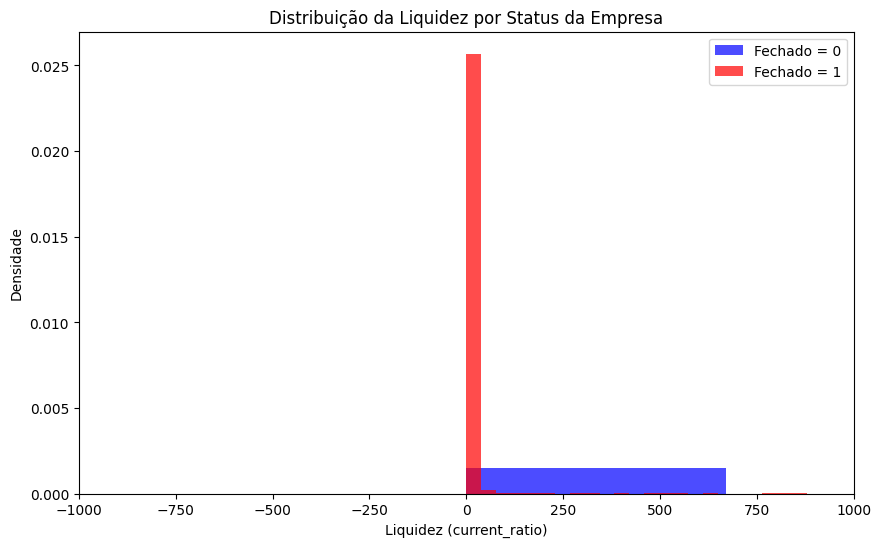

In [137]:
# Configurando as propriedades do gráfico
plt.figure(figsize=(10, 6))

# Histograma para empresas que não fecharam
plt.hist(data_2012["current_ratio"][data_2012['fechado'] == 0], bins=50, color='blue', alpha=0.7, label='Fechado = 0', density=True)

# Histograma para empresas que fecharam
plt.hist(data_2012["current_ratio"][data_2012['fechado'] == 1], bins=50, color='red', alpha=0.7, label='Fechado = 1', density=True)

# Definindo o título e os labels dos eixos
plt.title('Distribuição da Liquidez por Status da Empresa')
plt.xlabel('Liquidez (current_ratio)')
plt.ylabel('Densidade') # Mostrar densidade ao invés da contagem, dado a diferença entre a qtd de empresas fechadas e abertas
plt.legend()

# Definindo o limite para o eixo x 
plt.xlim(-1000, 1000)

# Mostrando o gráfico
plt.show()

In [138]:
# Separando os dados por grupo
group_0 = data_2012["current_ratio"][data_2012['fechado'] == 0]
group_1 = data_2012["current_ratio"][data_2012['fechado'] == 1]

# Calculando as estatísticas
stats_0 = {
    'mean': group_0.mean(),
    'median': group_0.median(),
    'std_dev': group_0.std(),
    'min': group_0.min(),
    'max': group_0.max(),
    '25_percentile': group_0.quantile(0.25),
    '50_percentile': group_0.quantile(0.50),
    '75_percentile': group_0.quantile(0.75),
    'iqr': group_0.quantile(0.75) - group_0.quantile(0.25),
    'mode': group_0.mode().iloc[0],  # Pega o primeiro valor da moda
    'skewness': group_0.skew(),
    'kurtosis': group_0.kurt(),
    'sample_size': len(group_0)
}

stats_1 = {
    'mean': group_1.mean(),
    'median': group_1.median(),
    'std_dev': group_1.std(),
    'min': group_1.min(),
    'max': group_1.max(),
    '25_percentile': group_1.quantile(0.25),
    '50_percentile': group_1.quantile(0.50),
    '75_percentile': group_1.quantile(0.75),
    'iqr': group_1.quantile(0.75) - group_1.quantile(0.25),
    'mode': group_1.mode().iloc[0],  # Pega o primeiro valor da moda
    'skewness': group_1.skew(),
    'kurtosis': group_1.kurt(),
    'sample_size': len(group_1)
}

# Criando DataFrames para exibir as estatísticas
df_stats_0 = pd.DataFrame(stats_0, index=['Fechado = 0'])
df_stats_1 = pd.DataFrame(stats_1, index=['Fechado = 1'])

# Concatenando os DataFrames
df_stats_current_ratio = pd.concat([df_stats_0, df_stats_1])

df_stats_current_ratio

,mean,median,std_dev,min,max,25_percentile,50_percentile,75_percentile,iqr,mode,skewness,kurtosis,sample_size
Fechado = 0,10.7,1.1,290.4,0.0,33519.0,0.3,1.1,2.7,2.4,0.0,93.1,10010.4,18613
Fechado = 1,6.3,0.3,58.8,0.0,1911.0,0.1,0.3,1.3,1.2,0.0,20.5,542.0,2339


Conforme evidenciado no histograma e nas estatísticas descritivas, destaca-se os pontos abaixo:
- A liquidez média das empresas que não fecharam é ligeiramente superior às que fecharam. 
- A alta assimetria e curtose sugerem que existem algumas empresas com liquidez extremamente alta, o que está distorcendo a média.
- O alto valor da moda em 0 indica que muitas empresas, em ambos os grupos, têm uma liquidez de zero.

### Margem de lucro

A Margem de Lucro mede a porcentagem de lucro que uma empresa obtém de suas vendas. Empresas com margens de lucro baixas podem ter dificuldades em absorver choques financeiros ou econômicos. Uma margem de lucro consistentemente baixa pode indicar problemas operacionais ou de eficiência, aumentando o risco de a empresa fechar no futuro.

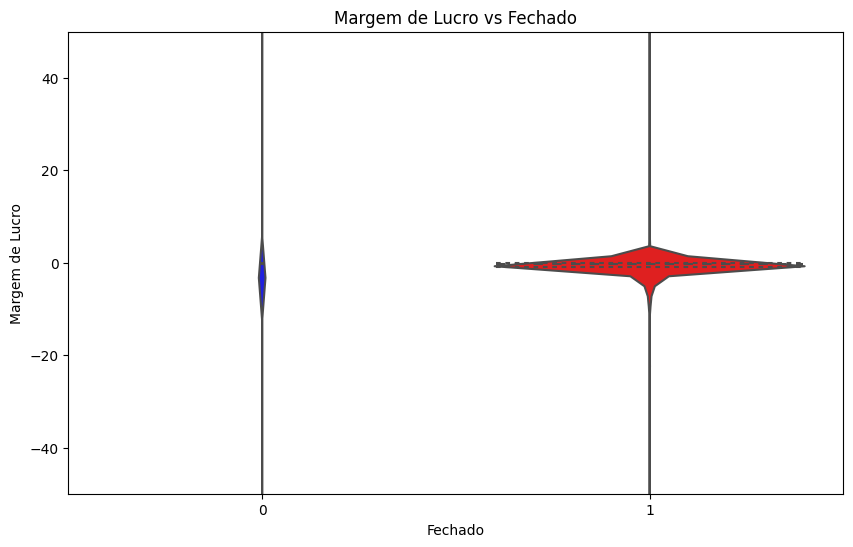

In [139]:
# Criar o violin plot da margem de lucro, separado por 'fechado'
plt.figure(figsize=(10, 6))
sns.violinplot(x="fechado", y="profit_margin", data=data_2012, palette={0: 'blue', 1: 'red'}, inner="quartile")

# Definir o título e os labels dos eixos
plt.title('Margem de Lucro vs Fechado')
plt.xlabel('Fechado')
plt.ylabel('Margem de Lucro')
plt.ylim(-50, 50)  # Definindo o limite para o eixo y

# Mostar o gráfico
plt.show()

In [140]:
# Separar os dados por grupo e por profit_margin
group_0_profit_margin = data_2012["profit_margin"][data_2012['fechado'] == 0]
group_1_profit_margin = data_2012["profit_margin"][data_2012['fechado'] == 1]

# Calcular as estatísticas
stats_0_profit_margin = {
    'mean': group_0_profit_margin.mean(),
    'median': group_0_profit_margin.median(),
    'std_dev': group_0_profit_margin.std(),
    'min': group_0_profit_margin.min(),
    'max': group_0_profit_margin.max(),
    '25_percentile': group_0_profit_margin.quantile(0.25),
    '50_percentile': group_0_profit_margin.quantile(0.50),
    '75_percentile': group_0_profit_margin.quantile(0.75),
    'iqr': group_0_profit_margin.quantile(0.75) - group_0_profit_margin.quantile(0.25),
    'mode': group_0_profit_margin.mode().iloc[0],  
    'skewness': group_0_profit_margin.skew(),
    'kurtosis': group_0_profit_margin.kurt(),
    'sample_size': len(group_0_profit_margin)
}

stats_1_profit_margin = {
    'mean': group_1_profit_margin.mean(),
    'median': group_1_profit_margin.median(),
    'std_dev': group_1_profit_margin.std(),
    'min': group_1_profit_margin.min(),
    'max': group_1_profit_margin.max(),
    '25_percentile': group_1_profit_margin.quantile(0.25),
    '50_percentile': group_1_profit_margin.quantile(0.50),
    '75_percentile': group_1_profit_margin.quantile(0.75),
    'iqr': group_1_profit_margin.quantile(0.75) - group_1_profit_margin.quantile(0.25),
    'mode': group_1_profit_margin.mode().iloc[0],  
    'skewness': group_1_profit_margin.skew(),
    'kurtosis': group_1_profit_margin.kurt(),
    'sample_size': len(group_1_profit_margin)
}

# Criar dataframe para exibir profit_margin
df_stats_0_profit_margin = pd.DataFrame(stats_0_profit_margin, index=['Fechado = 0'])
df_stats_1_profit_margin = pd.DataFrame(stats_1_profit_margin, index=['Fechado = 1'])

# Concatenar DataFrames por profit_margin
df_stats_profit_margin_final = pd.concat([df_stats_0_profit_margin, df_stats_1_profit_margin])

df_stats_profit_margin_final

,mean,median,std_dev,min,max,25_percentile,50_percentile,75_percentile,iqr,mode,skewness,kurtosis,sample_size
Fechado = 0,-0.2,0.0,5.7,-136.9,752.1,-0.2,0.0,0.0,0.2,0.0,120.8,16007.9,18613
Fechado = 1,-0.7,-0.3,4.0,-66.2,144.9,-0.9,-0.3,0.0,0.9,0.0,18.4,771.3,2339


Conforme observado no gráfico e nas estatística descritivas, podemos inferir que a margem de lucro é uma variável importante a ser considerada ao analisar a sobrevivência de uma empresa. A margem de lucro média é negativa para ambas as categorias de empresas, mas as empresas que fecharam têm uma margem de lucro ligeiramente mais negativa em média. No entanto, a variabilidade nas margens de lucro é maior entre as empresas que permaneceram abertas. Isso sugere que, enquanto algumas empresas que permaneceram abertas podem estar enfrentando desafios financeiros, outras estão prosperando e gerando altos lucros.

### Relação Dívida/Patrimônio Líquido

A Relação Dívida/Patrimônio Líquido indica quanto de financiamento a empresa obteve por dívida em relação ao seu patrimônio líquido. Uma alta relação pode sugerir que a empresa está excessivamente endividada, o que pode aumentar o risco financeiro. Empresas altamente endividadas podem enfrentar desafios em cumprir suas obrigações, especialmente em tempos de instabilidade econômica, elevando o risco de encerramento.

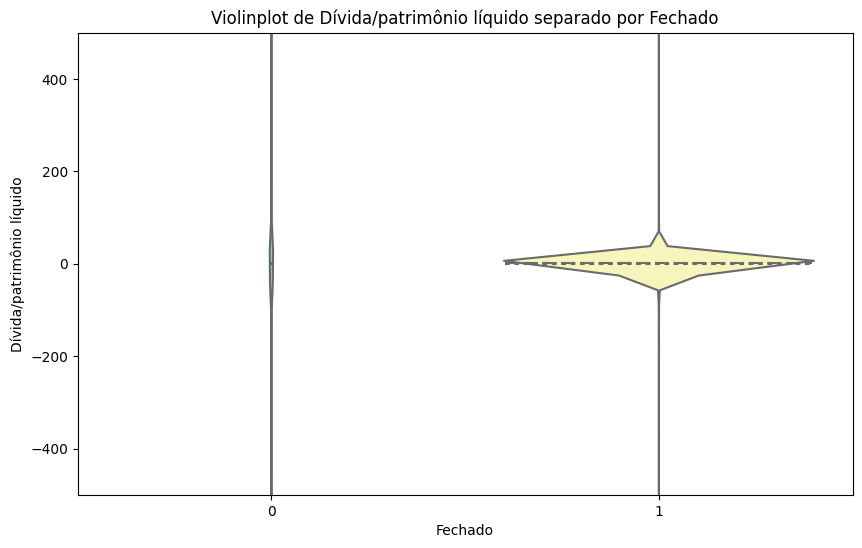

In [141]:
plt.figure(figsize=(10, 6))

sns.violinplot(x="fechado", y="debt_equity_ratio", data=data_2012, palette="Set3", inner="quartile")

plt.title('Violinplot de Dívida/patrimônio líquido separado por Fechado')
plt.xlabel('Fechado')
plt.ylabel('Dívida/patrimônio líquido')
plt.ylim(-500, 500)  # Definindo o limite para o eixo y

plt.show()

In [142]:
# Separar os dados por grupo
group_0 = data_2012["debt_equity_ratio"][data_2012['fechado'] == 0]
group_1 = data_2012["debt_equity_ratio"][data_2012['fechado'] == 1]

# Calcular as estatísticas
stats_0 = {
    'mean': group_0.mean(),
    'median': group_0.median(),
    'std_dev': group_0.std(),
    'min': group_0.min(),
    'max': group_0.max(),
    '25_percentile': group_0.quantile(0.25),
    '50_percentile': group_0.quantile(0.50),
    '75_percentile': group_0.quantile(0.75),
    'iqr': group_0.quantile(0.75) - group_0.quantile(0.25),
    'mode': group_0.mode().iloc[0],  # Pega o primeiro valor da moda
    'skewness': group_0.skew(),
    'kurtosis': group_0.kurt(),
    'sample_size': len(group_0)
}

stats_1 = {
    'mean': group_1.mean(),
    'median': group_1.median(),
    'std_dev': group_1.std(),
    'min': group_1.min(),
    'max': group_1.max(),
    '25_percentile': group_1.quantile(0.25),
    '50_percentile': group_1.quantile(0.50),
    '75_percentile': group_1.quantile(0.75),
    'iqr': group_1.quantile(0.75) - group_1.quantile(0.25),
    'mode': group_1.mode().iloc[0],  # Pega o primeiro valor da moda
    'skewness': group_1.skew(),
    'kurtosis': group_1.kurt(),
    'sample_size': len(group_1)
}

# Criar DataFrames para exibir as estatísticas
df_stats_0 = pd.DataFrame(stats_0, index=['Fechado = 0'])
df_stats_1 = pd.DataFrame(stats_1, index=['Fechado = 1'])

# Concatenar os DataFrames
df_stats_debt_equity_ratio = pd.concat([df_stats_0, df_stats_1])

df_stats_debt_equity_ratio

,mean,median,std_dev,min,max,25_percentile,50_percentile,75_percentile,iqr,mode,skewness,kurtosis,sample_size
Fechado = 0,-1.4,0.1,52.7,-5186.1,1688.7,-0.6,0.1,1.0,1.6,1.0,-54.3,5295.6,18613
Fechado = 1,-1.8,1.0,71.3,-2481.7,613.5,0.0,1.0,1.2,1.1,1.0,-30.9,1037.5,2339


A razão dívida/patrimônio líquido tem uma grande variação entre as empresas. Há uma presença significativa de valores negativos.

### Giro de Ativos

O Giro de Ativos mede a eficiência com que a empresa utiliza seus ativos para gerar vendas. Um giro de ativos baixo pode indicar ineficiência na utilização dos ativos. Empresas que não utilizam eficientemente seus ativos podem enfrentar dificuldades de crescimento e rentabilidade, o que pode influenciar negativamente sua viabilidade a longo prazo.

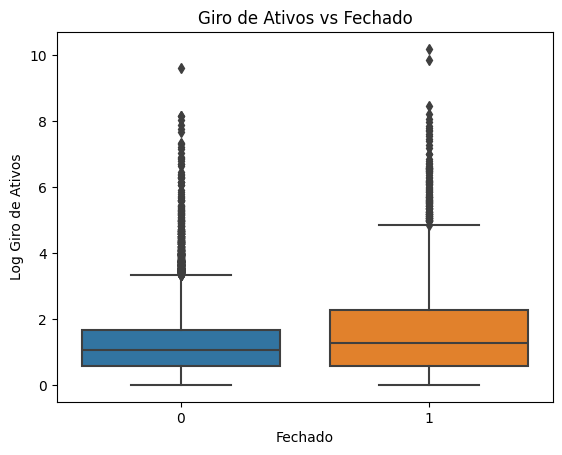

In [143]:
# Criando o boxplot da margem de lucro, separado por 'fechado'
sns.boxplot(x=data_2012['fechado'], y=np.log1p(data_2012["asset_turnover"]))

# Definindo o título e os labels dos eixos
plt.title('Giro de Ativos vs Fechado')
plt.xlabel('Fechado')
plt.ylabel('Log Giro de Ativos')

# Mostrando o gráfico
plt.show()

A razão dívida/patrimônio líquido tem uma grande variação entre as empresas. Há uma presença significativa de valores negativos, que podem ser outliers ou indicar uma situação financeira atípica. 

In [144]:
# Separando os dados por grupo para asset_turnover
group_0 = data_2012["asset_turnover"][data_2012['fechado'] == 0]
group_1 = data_2012["asset_turnover"][data_2012['fechado'] == 1]

# Calculando as estatísticas
stats_0 = {
    'mean': group_0.mean(),
    'median': group_0.median(),
    'std_dev': group_0.std(),
    'min': group_0.min(),
    'max': group_0.max(),
    '25_percentile': group_0.quantile(0.25),
    '50_percentile': group_0.quantile(0.50),
    '75_percentile': group_0.quantile(0.75),
    'iqr': group_0.quantile(0.75) - group_0.quantile(0.25),
    'mode': group_0.mode().iloc[0],  # Pega o primeiro valor da moda
    'skewness': group_0.skew(),
    'kurtosis': group_0.kurt(),
    'sample_size': len(group_0)
}

stats_1 = {
    'mean': group_1.mean(),
    'median': group_1.median(),
    'std_dev': group_1.std(),
    'min': group_1.min(),
    'max': group_1.max(),
    '25_percentile': group_1.quantile(0.25),
    '50_percentile': group_1.quantile(0.50),
    '75_percentile': group_1.quantile(0.75),
    'iqr': group_1.quantile(0.75) - group_1.quantile(0.25),
    'mode': group_1.mode().iloc[0],  # Pega o primeiro valor da moda
    'skewness': group_1.skew(),
    'kurtosis': group_1.kurt(),
    'sample_size': len(group_1)
}

# Criando DataFrames para exibir as estatísticas
df_stats_0_asset_turnover = pd.DataFrame(stats_0, index=['Fechado = 0'])
df_stats_1_asset_turnover = pd.DataFrame(stats_1, index=['Fechado = 1'])

# Concatenando os DataFrames
df_stats_asset_turnover = pd.concat([df_stats_0_asset_turnover, df_stats_1_asset_turnover])

df_stats_asset_turnover


,mean,median,std_dev,min,max,25_percentile,50_percentile,75_percentile,iqr,mode,skewness,kurtosis,sample_size
Fechado = 0,7.5,1.9,127.0,0.0,15084.0,0.8,1.9,4.3,3.6,0.0,94.5,10772.0,18613
Fechado = 1,56.4,2.5,715.9,0.0,26848.0,0.8,2.5,8.8,8.0,0.0,31.0,1061.6,2339


Os dados sugerem que, embora a média do giro de ativos seja mais alta para empresas que fecharam, a mediana é semelhante entre os dois grupos. Além disso, a variabilidade no giro de ativos é significativamente maior para empresas que fecharam. A presença de valores extremos é evidente em ambos os grupos, mas é mais pronunciada para empresas que não fecharam.

É importante enfatizar que as análises apresentadas não determinam definitivamente quais variáveis devem ser incluídas no modelo. As quatro variáveis criadas servirão como opções a serem consideradas em diferentes modelos, e sua relevância será avaliada individualmente para cada um deles.

## Limpeza de variáveis provisórias
As variáveis "sales_x1" e "sales_x2" foram usadas na criação da variável dependente mas não são apropriadas para entrarem no modelo (constituiriam um data leak).
Como filtramos pelo ano de 2012, tambem não usaremos a variável "year" na modelagem.

In [145]:
data_2012 = data_2012.drop(columns=['sales_x1','sales_x2', 'year', 'nace_main', 'comp_id', 'sales', 'balsheet_length'])

#data_2012 = data_2012.drop(columns=['sales_x1','sales_x2', 'year'])

## Matriz de correlação

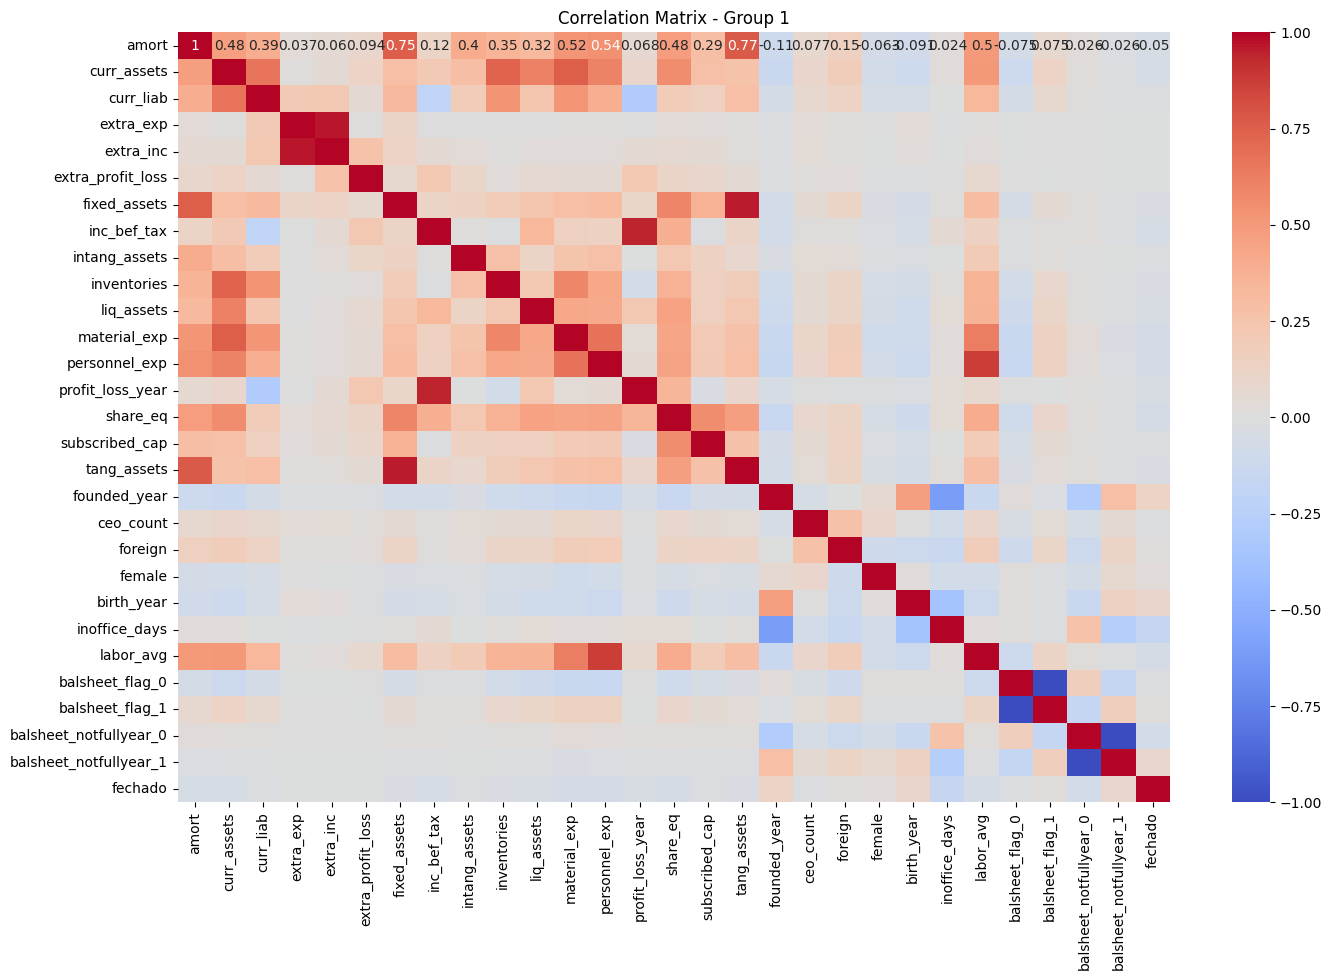

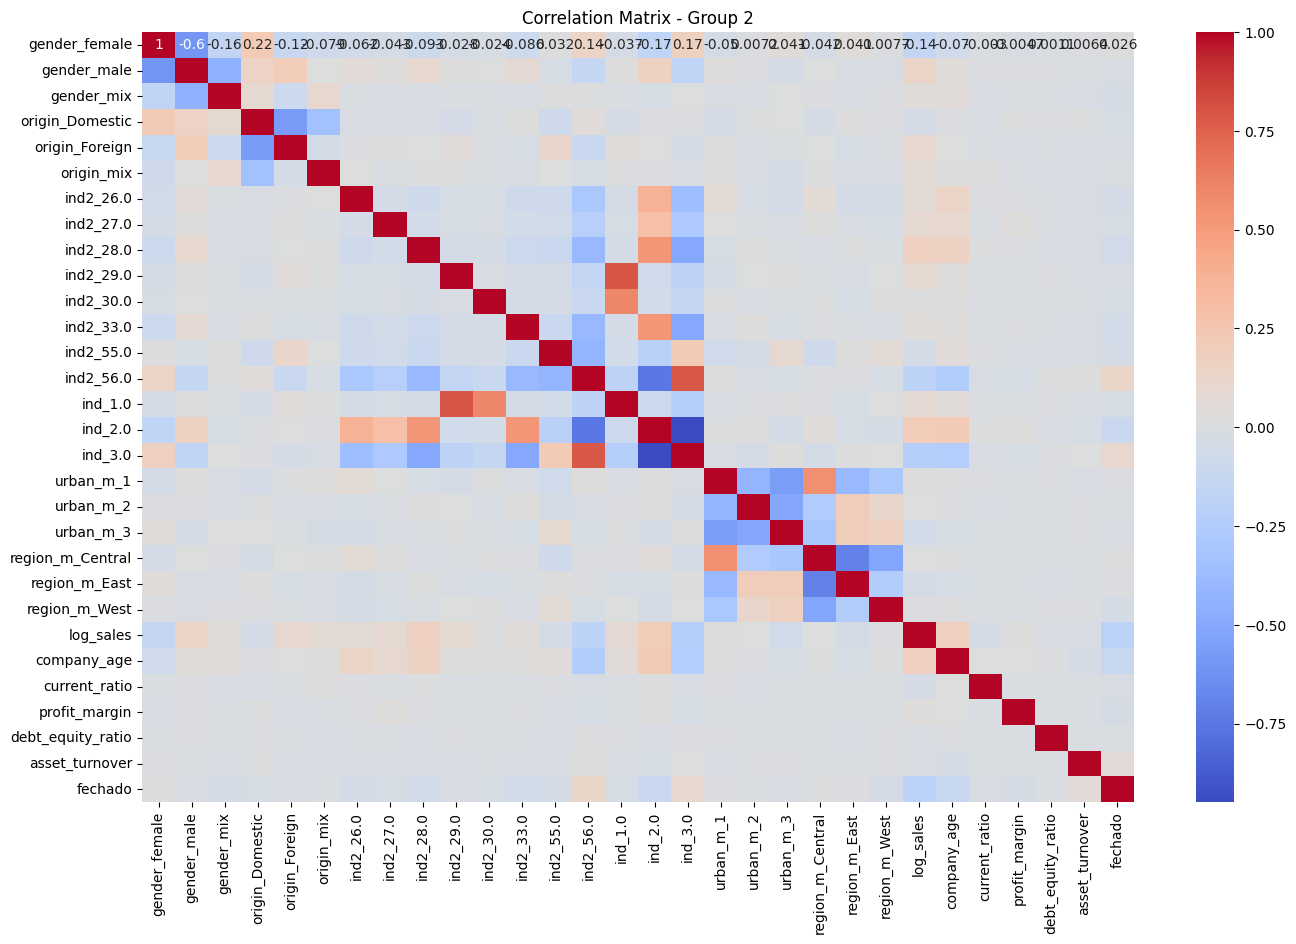

In [146]:
# Considera apenas colunas numéricas
numeric_cols = [col for col in data_2012.columns if data_2012[col].dtype in ['int64', 'float64']]

# Remover 'comp_id' da lista de colunas numéricas
if 'comp_id' in numeric_cols:
    numeric_cols.remove('comp_id')

# Lista todas as colunas numéricas exceto "dependente"
cols = [col for col in numeric_cols if col != 'fechado']

# Dividi as colunas em dois grupos
half = len(cols) // 2
group1 = cols[:half] + ['fechado']
group2 = cols[half:] + ['fechado']

# Cria as duas matrizes de correlação
correlation_matrix1 = data_2012[group1].corr()
correlation_matrix2 = data_2012[group2].corr()

# Visualiza a primeira matriz de correlação
plt.figure(figsize=(16,10))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Group 1')
plt.show()

# Visualiza a segunda matriz de correlação
plt.figure(figsize=(16,10))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Group 2')
plt.show()

In [147]:
missing_data_6 = show_missing(data_2012).sort_values("pc_missing", ascending=False, ignore_index = True)

missing_data_6.sort_values(by="variable", ignore_index=True)

,variable,dtype,count,unique,missing,pc_missing
0,amort,float64,20952,4708,0,0.0
1,asset_turnover,float64,20952,20878,0,0.0
2,balsheet_flag_0,float64,20952,2,0,0.0
3,balsheet_flag_1,float64,20952,2,0,0.0
4,balsheet_notfullyear_0,float64,20952,2,0,0.0
5,balsheet_notfullyear_1,float64,20952,2,0,0.0
6,birth_year,float64,20952,4901,0,0.0
7,ceo_count,float64,20952,1928,0,0.0
8,company_age,float64,20952,37,0,0.0
9,curr_assets,float64,20952,11321,0,0.0


Confirmamos que o banco de dados final gerado está completo, sem dados faltando através do processo de limpeza com alterações e remoções.

### Análise por agrupamento de variável dependente:
---

Vamos agrupar as empresas marcadas pela variável dependente (fechada) para buscar visualizar algumas das tendências das empresas que fecharam no ano de 2012:

In [148]:
# Filtrando apenas colunas numéricas
numeric_data_2012 = data_2012.select_dtypes(include=[np.number])

# Agrupando pelo campo "fechado"
groups_2012 = numeric_data_2012.groupby(by="fechado")

# Realizando agregação
df_groups = groups_2012.agg(['mean', 'median'])

df_groups

amort        curr_assets         curr_liab         extra_exp         \
          mean median        mean  median      mean  median      mean median   
fechado                                                                        
0       9962.8 1018.5    106766.9 12388.9   90762.9 14214.8    1340.7    0.0   
1       2014.8  155.6     30317.2  3525.9   54391.0 13596.3     418.6    0.0   

        extra_inc         ... company_age        current_ratio         \
             mean median  ...        mean median          mean median   
fechado                   ...                                           
0          2555.7    0.0  ...         8.9    8.0          10.7    1.1   
1          1237.6    0.0  ...         6.1    3.0           6.3    0.3   

        profit_margin        debt_equity_ratio        asset_turnover         
                 mean median              mean median           mean median  
fechado                                                                      
0                -0.2    0.0              -1.4    0.1            7.5    1.9  
1                -0.7   -0.3              -1.8    1.0           56.4    2.5  

[2 rows x 114 columns]

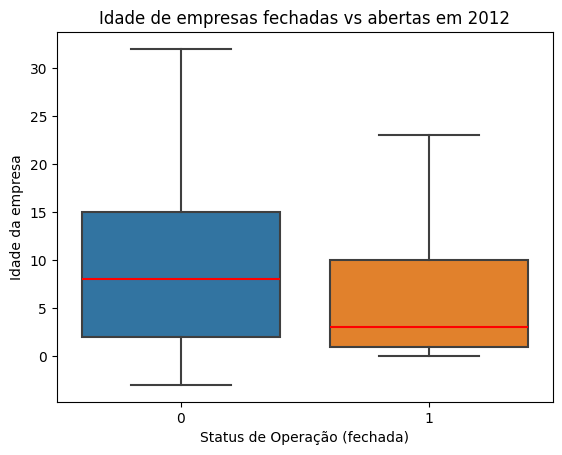

valores médios de idade da empresa:
fechado
0   8.9
1   6.1
Name: mean, dtype: float64


In [149]:
sns.boxplot(data=data_2012, x='fechado', y='company_age', 
            showfliers = False, medianprops = {"color":"red"})

# Configuração do gráfico:
plt.xlabel('Status de Operação (fechada)')
plt.ylabel('Idade da empresa')
plt.title('Idade de empresas fechadas vs abertas em 2012')

# Show the plot
plt.show()

print("valores médios de idade da empresa:")
print(df_groups["company_age"]['mean'])

In [150]:
def group_box(column, data = data_2012):
    ''' Funcao para rodar boxplot agrupado '''
    sns.boxplot(data=data, x='fechado', y=column, 
            showfliers = False, medianprops = {"color":"red"})

    # Configuração do gráfico:
    plt.xlabel('Status de Operação (fechada)')
    plt.ylabel(f'Valor variável "{column}"')
    plt.title('Análise agrupada {column}')

    # Show the plot
    plt.show()

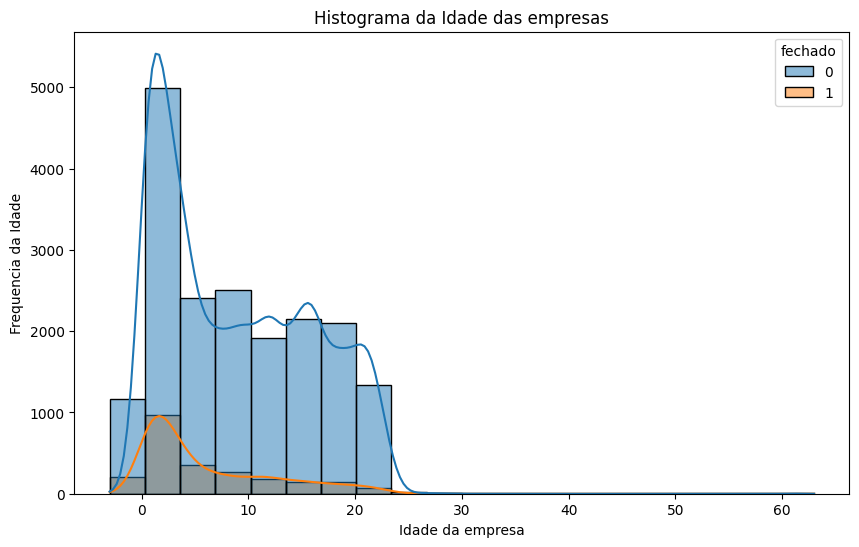

In [151]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create histograms for each group using Seaborn
sns.histplot(data=data_2012, x='company_age', hue='fechado', bins=20, alpha=0.5, ax=ax, kde=True)

# Set labels and title
ax.set_xlabel('Idade da empresa')
ax.set_ylabel('Frequencia da Idade')
ax.set_title('Histograma da Idade das empresas')

# Show the plot
plt.show()

In [152]:
def group_hist(column, data=data_2012):
    ''' Funcao para gerar o histograma com linha de tendencia agrupado'''
    
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create histograms for each group using Seaborn
    sns.histplot(data=data, x=column, hue='fechado', bins=20, alpha=0.5, ax=ax, kde=True)

    # Set labels and title
    ax.set_xlabel(f'valor da variável {column}')
    ax.set_ylabel(f'Frequência da variável {column}')
    ax.set_title(f'Histograma de {column}')

    # Show the plot
    plt.show()

O grupo de empresas abertas mostra cauda à direita mais substancial que as outras, indicando uma menor tendencia de empresas mais velhas fecharem relativo ao mesmo risco para empresas mais novas.

#### Amortização

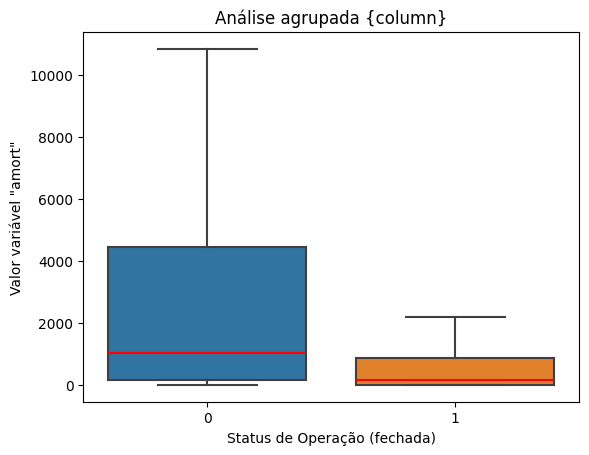

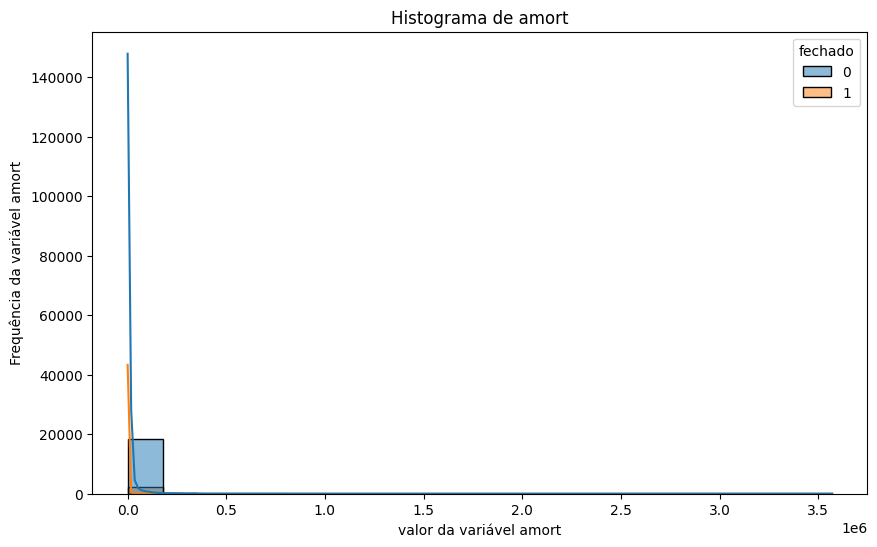

In [153]:
group_box("amort")
group_hist("amort")

Vamos converter para log para conseguirmos analisar melhor as tendências

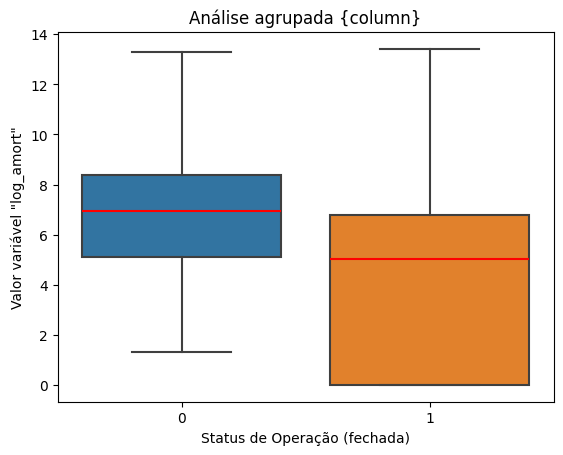

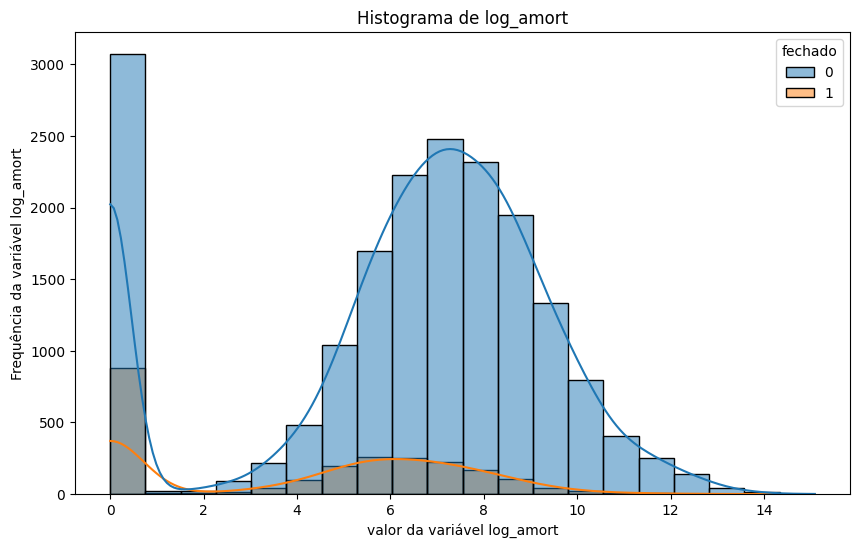

In [154]:
criar_log(data_2012, "amort")

group_box("log_amort")
group_hist("log_amort")

O logarítmo da amortização tem distribuição aparentemente normal com cauda à esquerda tanto para as empresas abertas quanto para as fechadas. A distribuição para as empresas abertas tem centro maior do que as outras, sugerindo que um maior valor para o logarítmo da amortização pode indicar maior probabilidade de a empresa estar aberta.

Tendo confirmado uma distribuição mais razoavel para o logarítmo de amortizacção do que para a variável original, tiramos "amort" da base e deixamos "log_amort".

In [155]:
data_2012.drop(columns = "amort", inplace=True)

In [157]:
#group_hist("ind")

A proporção de empresas fechadas parece se manter por indústria. Dadas as diferenças de escala na quantidade de empresas por indústria, conferimos essas proporções numericamente.

In [158]:
def proportion_1(column, data=data_2012):
    '''Funcao retorna proporcao de fechado para cada caso'''

    industry_effect = data_2012.groupby(["fechado", column])[column].count()

    pivot_table = data_2012.pivot_table(index=column, columns='fechado', aggfunc='size', fill_value=0)

    # calcular proporção
    pivot_table['Proportion'] = pivot_table[1] / (pivot_table[0] + pivot_table[1])

    # Reset the index to make 'ind' a regular column
    # Resetando index para fazer "ind" uma coluna normal
    pivot_table = pivot_table.reset_index()

    # Renomeando por clareza
    pivot_table.columns = [column, '0_Count', '1_Count', 'Proporcao_1']

    return pivot_table

In [161]:
#print(proportion_1("ind"))

A analise dos números confirma proporcoes aproximadamente iguais de empresas fechadas para abertas por indústria, indicando baixo poder de previsão dessa variável. Por isso retiramos da base as duas variáveis referentes à industria.

In [162]:
#data_2012.drop(columns = ["ind","ind2"], inplace=True)

Agora vamos ordenar por significancia nossas variáveis e verificar os resultados:

Variáveis como "comp_id" número da impressa não deveriam interferir na predição pois são valores arbitrarios de registro de cada empresa.

## Exportação da base tratada para modelagem

In [163]:
data_2012.to_csv("data_2012.csv", index=False)

In [164]:
data_2012.columns

Index(['curr_assets', 'curr_liab', 'extra_exp', 'extra_inc',
       'extra_profit_loss', 'fixed_assets', 'inc_bef_tax', 'intang_assets',
       'inventories', 'liq_assets', 'material_exp', 'personnel_exp',
       'profit_loss_year', 'share_eq', 'subscribed_cap', 'tang_assets',
       'founded_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'labor_avg', 'balsheet_flag_0', 'balsheet_flag_1',
       'balsheet_notfullyear_0', 'balsheet_notfullyear_1', 'gender_female',
       'gender_male', 'gender_mix', 'origin_Domestic', 'origin_Foreign',
       'origin_mix', 'ind2_26.0', 'ind2_27.0', 'ind2_28.0', 'ind2_29.0',
       'ind2_30.0', 'ind2_33.0', 'ind2_55.0', 'ind2_56.0', 'ind_1.0',
       'ind_2.0', 'ind_3.0', 'urban_m_1', 'urban_m_2', 'urban_m_3',
       'region_m_Central', 'region_m_East', 'region_m_West', 'fechado',
       'log_sales', 'company_age', 'current_ratio', 'profit_margin',
       'debt_equity_ratio', 'asset_turnover', 'log_amort'],
      dtype='ob